<a href="https://colab.research.google.com/github/saeu5407/daily_tensorflow/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이학습(Transfer Learning) & 미세조정(Fine-tuning)

### **전이 학습**
**전이 학습**은 한 가지 문제에 대해 학습한 기능을 가져와서 비슷한 새로운 문제에 활용하는 것으로 구성됩니다. 예를 들어, 라쿤을 식별하는 방법을 배운 모델의 기능은 너구리를 식별하는 모델을 시작하는 데 유용할 수 있습니다.
Transfer Learning은 일반적으로 풀 스케일 모델을 처음부터 훈련하기에는 데이터세트에 데이터가 너무 적은 작업에 대해 수행됩니다.

다음은 전이학습의 일반적인 워크플로우입니다.
1. 이전에 훈련된 모델에서 레이어를 가져옵니다.
2. 추후 훈련 라운드 중에 포함 된 정보가 손상되지 않도록 고정하십시오.
3. 고정된 레이어 위에 훈련할 수 있는 새 레이어를 추가합니다. 해당 레이어는 기존 기능을 새로운 데이터세트에 대한 예측으로 전환하는 방법을 배웁니다.
4. 데이터세트에서 새로운 레이어를 훈련합니다.

### **Fine-tuning**
**파인-튜닝**은 전이학습으로 얻은 모델에 대해 가중치 동결을 해제하고, 학습 속도가 낮은 새로운 데이터에 대해 재훈련을 하는 방법입니다.

보통 전이학습은 마지막 FC레이어를 변경하는 방식으로 사용하는데, 파인-튜닝을 하고자 한다면 전이학습을 통해 새로 연결한 FC레이어의 **가중치를 미리 업데이트**해야 합니다.
무작위로 초기되어 있는 가중치는 사전 훈련된 특성에 문제를 야기할 수 있기 때문입니다.

또한 앞서 말했듯이 **매우 낮은 학습속도로 작업**해야 합니다. 사전훈련된 모델은 매우 큰 모델이기 때문에 큰 가중치가 업데이트 된다면 과도하게 빠른 과적합 위험이 있습니다.

Fine tuning은 4가지 유형으로 나눌 수 있습니다.
1. Small dataset and similar to the pre-trained model`s dataset
2. Large dataset and similar to the pre-trained model`s dataset
3. Large dataset and different from the pre-trained model`s dataset
4. Small dataset and different from the pre-trained model`s dataset

**첫 번째 유형**은 데이터셋이 적지만, Pre-train된 데이터 셋과 비슷한 특징을 가지는 경우입니다.(도메인이 비슷하다?) 이 때는 전체 네트워크에 대해 Fine-tuning을 할 경우 오버피팅 문제가 발생할 수 있기에 FC layer에만 기존 모델의 1/10 수준의 lr을 적용하여 가중치를 업데이트하게 됩니다.

정리하면,</br>
Conv layer lr = 0</br>
FC layer lr = 기존lr/10

**두 번째 유형**은 데이터셋이 충분하면서, Pre-train된 데이터 셋과 비슷한 특징을 가지는 경우입니다. 이 경우에는 전체에 대해서 Fine-tuning을 진행해도 문제없지만 데이터셋이 유사하므로 일부 레이어만 기존 모델의 1/10 수준의 lr을 적용하여 가중치를 업데이트합니다.

정리하면,</br>
Conv layer 일부 lr = 기존lr/10</br>
FC layer lr = 기존lr/10

**세 번째 유형**은 데이터는 충분하나 기존 pre-trained 데이터와는 도메인이 다른 경우입니다. 이 경우는 전체를 Fine-tuning하는 것이 좋습니다.

정리하면,</br>
Conv layer lr = 기존lr/10</br>
FC layer lr = 기존lr/10

**마지막 유형**은 데이터도 부족하고 기존과 다른 데이터셋일 경우입니다. 가장 문제인 부분으로 적당한 양의 레이어만 Fine-tuning해야 하지만 쉽지 않다고 합니다.

정리하면,</br>
Conv layer 일부 lr = 기존lr/10</br>
FC layer lr = 기존lr/10

### 레이어 동결: trainable 속성 이해
레이어 및 모델에는 세 가지 가중치 속성이 있습니다.

- weights는 레이어의 모든 가중치 변수 목록입니다.
- trainable_weights는 훈련 중 손실을 최소화하기 위해 업데이트(그래디언트 디센트를 통해)되어야 하는 목록입니다.
- non_trainable_weights는 훈련되지 않은 것들의 목록입니다. 일반적으로 순방향 전달 중에 모델에 의해 업데이트됩니다.

**참고: `Dense` 레이어에는 2개의 학습 가능한 가중치가 있습니다.**</br>
**참고: `BatchNormalization` 레이어에는 2개의 훈련 가능한 가중치와 2개의 훈련할 수 없는 가중치가 있습니다.**

In [1]:
# 참고 : 레이어 동결
import numpy as np
import tensorflow as tf
from tensorflow import keras

inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model # 모델 전체를 훈련하지 못하게 막는 법

assert inner_model.trainable == False  # All layers in `model` are now frozen, 모두 막는법
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively # 하위 레이어만 막는법.

# 예제 : 고양이 vs 개 데이터세트 이미지분류 Fine-tuning
사전 훈련 모델인 Xception 모델을 가지고 Kaggle "cats vs. dogs" 분류 데이터세트에서 전이학습 및 fine tuning을 진행해보겠습니다.

In [2]:
# 데이터 로드
"""
전이학습은 작은 데이터로 작업할 때 유용하다고 합니다. 이를 위해 전체 데이터셋의 60%만 사용하겠습니다.
Train 40% / Valid 10% / Test 10%
"""
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


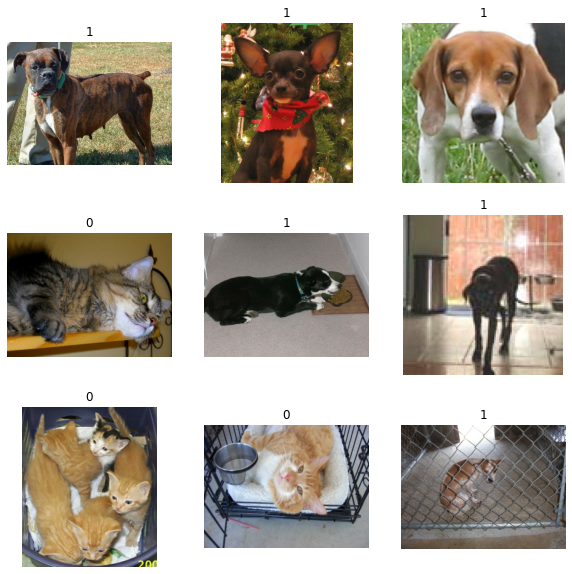

In [3]:
# 데이터 샘플 시각화
"""
처음 9개 샘플 이미지입니다.
- 이미지의 크기가 다르다는 점,
- 레이블 1이 "개", 0이 "고양이"인 점을 알 수 있습니다.
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [4]:
# 데이터 전처리
"""
데이터 전처리로는 3가지 정도를 생각해 볼 수 있습니다.

1. 이미지 크기가 다르므로 이를 같은 크기로 맞춰야 합니다.
2. 정수 값을 정규화합니다. -> 다만 여기서는 모델 일부에 Normalization을 사용할 것입니다.
3. 데이터를 증강합니다.
"""
# 데이터 크기 조정
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

# 데이터 캐싱, 프리페치
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# 데이터 증강
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

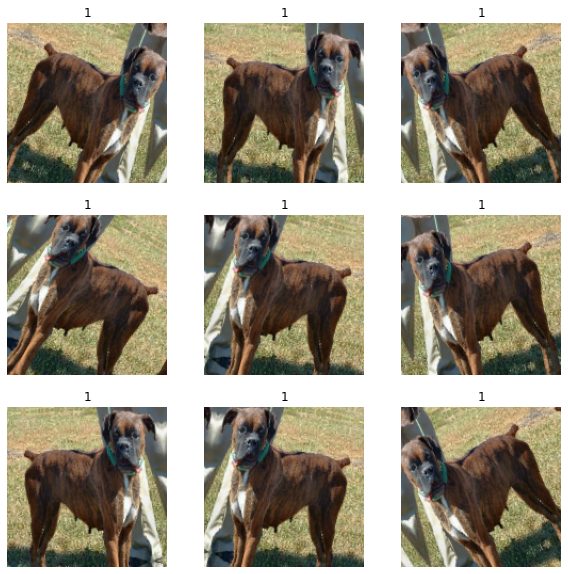

In [5]:
# 데이터 증강에 대한 시각화.
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [6]:
# 사전훈련 모델 불러오기
base_model = keras.applications.Xception(
    weights="imagenet",  # ImageNet에 대해 pre-trained된 모델입니다.
    input_shape=(150, 150, 3),
    include_top=False, # 이미지넷 분류기를 제거합니다.
)  

# 데이터 레이어 동결
base_model.trainable = False

# include_top=False옵션으로 제거한 Top 부분을 새로 작업하여 붙입니다.
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Normalization을 합니다.
# Rescaling으로 간단하게~
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
x = rescale(x)

# 마지막으로 GAP, 최종 Dense 등을 추가하여 마무리합니다.
"""
기본 모델을 호출 할 때 training=False를 전달합니다.
추론 모드에서 실행되므로 fine-tuning을 위해 기본 모델을 동결 해제한 후에도 batchnorm 통계가 업데이트되지 않습니다.
"""
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049  

In [ ]:
# 최상위 레이어를 훈련합니다.
# 헷갈리는 부분인데 최하위가 아니라 왜 반대인 최상위인지는 모르겠으나 분류 직전 추가한 부분에 대한 훈련입니다.
# 즉 이 부분이 전이학습(Transfer Learning) 부분입니다.
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True), # 2클래스 바이너리크로스엔트로피라 True 옵션을 넣었습니다.
    metrics=[keras.metrics.BinaryAccuracy()], 
)

epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
291/291 [==============================] - 920s 3s/step - loss: 0.1069 - binary_accuracy: 0.9558 - val_loss: 0.0727 - val_binary_accuracy: 0.9721
Epoch 2/5
291/291 [==============================] - 915s 3s/step - loss: 0.1069 - binary_accuracy: 0.9546 - val_loss: 0.0748 - val_binary_accuracy: 0.9699
Epoch 3/5
250/291 [========================>.....] - ETA: 1:43 - loss: 0.0992 - binary_accuracy: 0.9600

In [ ]:
# Fine-tuning을 수행합니다.
"""
현재 기본 모델을 호출할 때 training=False를 전달했기 때문에 추론 모드입니다.
이로 인해 배치 정규화 레이어에서는 업데이트가 일어나지 않습니다. 그렇기 때문에 동결을 풀어주는 옵션을 추가합니다.

여기서 확인할 수 있는 다른 건 Adam의 lr이 매우 낮게 지정되어있다는 점입니다.
"""
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5), # Low learning rate를 지정했다는 걸 확인할 수 있습니다.
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)